In [167]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import rasterio.features
import rasterio.warp
from pathlib import Path
import numpy as np
from shapely.geometry import mapping
from PIL import Image
import json

In [160]:
class Picture:
    
    def __init__(self, tif_filename):
        with rasterio.open(tif_filename) as dataset:
            self.left = dataset.bounds.left
            self.right = dataset.bounds.right
            self.bottom = dataset.bounds.bottom
            self.top = dataset.bounds.top
            self.dataset = dataset
            self.height = dataset.height
            self.width = dataset.width
    
    def polygon_in_picture(self, polygon):
        # Get the coordinates of the polygon
        coords = mapping(polygon)["coordinates"][0][1:]
        
        # Check if each coordinate of the polygon lies in our picture bounds
        in_picture = True
        for c in coords:
            x = c[0]
            y = c[1]
            if (x < self.left) or (x > self.right) or (y < self.bottom) or (y > self.top):
                in_picture = False
                break
        
        return in_picture
    
    def convert_polygon_to_pixels(self, polygon):
        # Get the coordinates of the polygon
        coords = mapping(polygon)["coordinates"][0][1:]
        
        # Return (xmin, ymin, xmax, ymax) of the polygon
        x_vals = []
        y_vals = []
        for c in coords:
            x = c[0]
            y = c[1]
            row, col = self.dataset.index(x,y)
            x_vals.append(max(0, min(col, self.width-1)))
            y_vals.append(max(0, min(row, self.height-1)))

        return([min(x_vals), min(y_vals), max(x_vals), max(y_vals)])
        
        

In [168]:
DATA_DIR = Path('data')

shp_mlbs = gpd.read_file('./data/train/ITC/train_MLBS.shp')
shp_osbs = gpd.read_file('./data/train/ITC/train_OSBS.shp')
all_polygons = np.concatenate([shp_mlbs['geometry'], shp_osbs['geometry']])

polygon_to_filename = {}
filename_to_polygon = {}

rgb_directory = DATA_DIR / Path('train') / 'RemoteSensing' / 'RGB'
for filename in os.listdir(directory):
    filename_key, extension = os.path.splitext(filename)
    if extension != '.tif':
        continue
    
    filename_to_polygon[filename_key] = []
    picture = Picture(directory / filename)
    
    for polygon in all_polygons:
        if not mapping(polygon)["coordinates"][0][1:] in polygon_to_filename:
            polygon_to_filename[mapping(polygon)["coordinates"][0][1:]] = []
            
        if picture.polygon_in_picture(polygon):
            polygon_to_filename[mapping(polygon)["coordinates"][0][1:]].append(filename_key)
            filename_to_polygon[filename_key].append(picture.convert_polygon_to_pixels(polygon))

with open('idtrees_gt.json', 'w') as fp:
    json.dump(filename_to_polygon, fp)

BoundingBox(left=542394.0, bottom=4136714.0, right=542414.0, top=4136734.0)


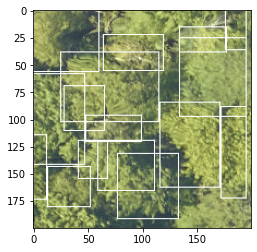

In [166]:
# Visualize results
filename = "MLBS_3"
boxes = filename_to_polygon[filename]

picture = Picture('data/train/RemoteSensing/RGB/{}.tif'.format(filename))
print(picture.dataset.bounds)

I = Image.open("data/train/RemoteSensing/rgb_png/{}.png".format(filename))
for b in boxes:
    # convert to numpy array:
    I = np.asarray(I).copy()

    for box in boxes:
        tl_col, tl_row, br_col, br_row = box

        # Left and right sides of box
        for i in range(tl_row, br_row+1):
            I[i][tl_col] = [255,255,255]
            I[i][br_col] = [255,255,255]

        # Top and bottom sides of box
        for j in range(tl_col, br_col+1):
            I[tl_row][j] = [255,255,255]
            I[br_row][j] = [255,255,255]

    # show image
    plt.imshow(I)